# 观察jena天气数据集

In [1]:
import os

In [2]:
data_dir = r'E:/Data'

In [3]:
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [4]:
f = open(fname)
data = f.read()
f.close

<function TextIOWrapper.close()>

In [5]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]  # 排除表头

In [6]:
print(header)

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [7]:
print(len(header))

15


In [8]:
print(len(lines))

420551


# 解析数据

In [9]:
import numpy as np

In [10]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

# 绘制温度时间序列

In [55]:
from matplotlib import pyplot as plt

In [12]:
temp = float_data[:, 1]

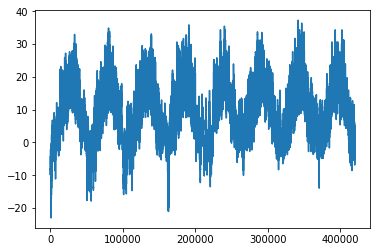

In [13]:
plt.plot(range(len(temp)), temp)

# 绘制前10天的温度时间序列

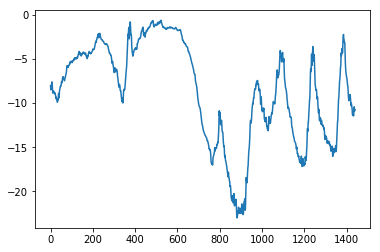

In [14]:
plt.plot(range(1440), temp[:1440])

# 准备数据

## 数据标准化

In [15]:
# 使用前200000个时间步作为训练数据

In [16]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

## 生成时间序列的样本及其目标的生成器

In [17]:
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

## 准备训练生成器、验证生成器和测试生成器

In [18]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

In [19]:
train_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step, batch_size=batch_size)

In [20]:
val_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=200001, max_index=300000, step=step, batch_size=batch_size)

In [21]:
test_gen = generator(data=float_data, lookback=lookback, delay=delay, min_index=300001, max_index=None, step=step, batch_size=batch_size)

In [22]:
val_steps = (300000 - 200001 - lookback) // batch_size

In [23]:
test_steps = (len(float_data) - 300001 - lookback) // batch_size

# 训练模型

## 一种基于常识的、非机器学习的基准方法

In [24]:
# 计算基准方法的MAE

In [29]:
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]  # 三个参数 [start_index:  stop_index:  step]
        mae = np.mean(np.mean(np.abs(preds - targets)))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [30]:
evaluate_naive_method()

0.2897359729905486


In [31]:
# 将MAE转换成摄氏度误差

In [35]:
celsius_mae = 0.29 * std[1];celsius_mae

2.5672247338393395

## 一种基本的机器学习方法

In [37]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [38]:
model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(units=32, activation='relu'))
model.add(layers.Dense(units=1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 3360)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                107552    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [39]:
model.compile(optimizer=RMSprop(), loss='mae')

In [40]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 18s - loss: 1.4718 - val_loss: 0.9166
Epoch 2/20
500/500 [==============================] - 16s - loss: 0.5227 - val_loss: 0.4126
Epoch 3/20
500/500 [==============================] - 16s - loss: 0.3058 - val_loss: 0.2940
Epoch 4/20
500/500 [==============================] - 16s - loss: 0.2726 - val_loss: 0.3002
Epoch 5/20
500/500 [==============================] - 16s - loss: 0.2563 - val_loss: 0.3222
Epoch 6/20
500/500 [==============================] - 16s - loss: 0.2488 - val_loss: 0.3228
Epoch 7/20
500/500 [==============================] - 16s - loss: 0.2378 - val_loss: 0.3255
Epoch 8/20
500/500 [==============================] - 16s - loss: 0.2328 - val_loss: 0.3202
Epoch 9/20
500/500 [==============================] - 16s - loss: 0.2276 - val_loss: 0.3263
Epoch 10/20
500/500 [==============================] - 16s - loss: 0.2215 - val_loss: 0.3232
Epoch 11/20
500/500 [==============================] - 16s - loss: 0.2199 - val

### 绘制结果

In [41]:
from matplotlib import pyplot as plt

In [42]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [43]:
epochs = range(1, len(loss) + 1)

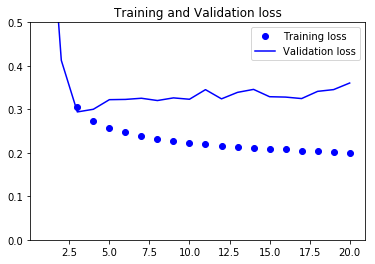

In [47]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim((0, 0.5))
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [49]:
np.mean(loss)

0.3041493668079376

## 第一个循环网络基准

In [50]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [52]:
model = Sequential()
model.add(layers.GRU(units=32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [53]:
model.compile(optimizer=RMSprop(), loss='mae')

In [54]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=20, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 199s - loss: 0.3024 - val_loss: 0.2710
Epoch 2/20
500/500 [==============================] - 202s - loss: 0.2851 - val_loss: 0.2693
Epoch 3/20
500/500 [==============================] - 191s - loss: 0.2776 - val_loss: 0.2602
Epoch 4/20
500/500 [==============================] - 188s - loss: 0.2731 - val_loss: 0.2598
Epoch 5/20
500/500 [==============================] - 199s - loss: 0.2657 - val_loss: 0.2623
Epoch 6/20
500/500 [==============================] - 225s - loss: 0.2636 - val_loss: 0.2625
Epoch 7/20
500/500 [==============================] - 188s - loss: 0.2579 - val_loss: 0.2733
Epoch 8/20
500/500 [==============================] - 194s - loss: 0.2553 - val_loss: 0.2670
Epoch 9/20
500/500 [==============================] - 196s - loss: 0.2495 - val_loss: 0.2698
Epoch 10/20
500/500 [==============================] - 198s - loss: 0.2455 - val_loss: 0.2706
Epoch 11/20
500/500 [==============================] - 196s - loss: 0

### 绘制结果

In [56]:
from matplotlib import pyplot as plt

In [57]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [58]:
epochs = range(1, len(loss) + 1)

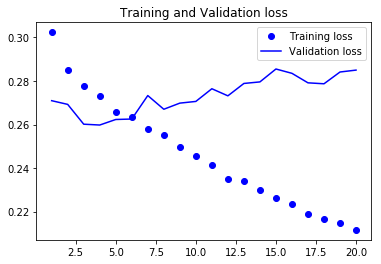

In [60]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

## 使用循环dropout来降低过拟合

### 训练并评估一个使用dropout正则化的基于GPU的模型

In [61]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

In [62]:
model = Sequential()
model.add(layers.GRU(units=32, dropout=0.2, recurrent_dropout=0.2, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(units=1))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_3 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile(optimizer=RMSprop(), loss='mae')  # RMSprop()一定要加括号

In [64]:
history = model.fit_generator(generator=train_gen, steps_per_epoch=500, epochs=40, validation_data=val_gen, validation_steps=val_steps)

Epoch 1/40
500/500 [==============================] - 251s - loss: 0.3346 - val_loss: 0.2780
Epoch 2/40
500/500 [==============================] - 247s - loss: 0.3163 - val_loss: 0.2703
Epoch 3/40
500/500 [==============================] - 252s - loss: 0.3089 - val_loss: 0.2711
Epoch 4/40
500/500 [==============================] - 232s - loss: 0.3035 - val_loss: 0.2687
Epoch 5/40
500/500 [==============================] - 228s - loss: 0.3002 - val_loss: 0.2669
Epoch 6/40
500/500 [==============================] - 240s - loss: 0.2985 - val_loss: 0.2700
Epoch 7/40
500/500 [==============================] - 234s - loss: 0.2951 - val_loss: 0.2689
Epoch 8/40
500/500 [==============================] - 239s - loss: 0.2941 - val_loss: 0.2634
Epoch 9/40
500/500 [==============================] - 256s - loss: 0.2940 - val_loss: 0.2639
Epoch 10/40
500/500 [==============================] - 233s - loss: 0.2905 - val_loss: 0.2634
Epoch 11/40
500/500 [==============================] - 214s - loss: 0

In [67]:
model.save('./gru_6_40.h5')

### 绘制结果

In [65]:
loss = history.history['loss']
val_loss = history.history['val_loss']

In [66]:
epochs = range(1, len(loss) + 1)

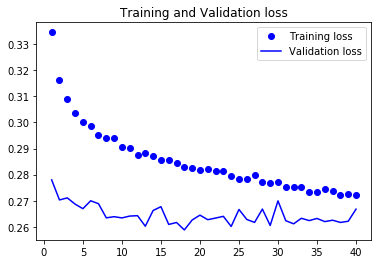

In [68]:
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [71]:
np.mean(loss)

0.28552781146988276